# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
from scipy.interpolate import griddata
import seaborn as sns
from matplotlib.patches import Patch
from scipy.stats import ttest_rel

c:\Users\flmun\OneDrive\Documents\EPFL\MA1\Anaconda\envs\flygym\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\flmun\OneDrive\Documents\EPFL\MA1\Anaconda\envs\flygym\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\flmun\OneDrive\Documents\EPFL\MA1\Anaconda\envs\flygym\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Read preprocessed data

In [2]:
# After preprocessing of simulation data, we stored all obtained dataframes in a pickle structure
df_original = pd.read_pickle('preprocessed_data_w_4000.pkl')

# Useful functions

In [3]:
# Define function to compute a new vector based on a previous vector and an given angle
def find_vector_given_angle(previous_heading, angle_degrees):
    # Normalize the previous_heading vector
    previous_heading_normalized = previous_heading / np.linalg.norm(previous_heading)

    # Compute the rotation matrix for 2D rotation with the corrected sign
    rotation_matrix = np.array([[np.cos(np.radians(angle_degrees)), -np.sin(np.radians(angle_degrees))],
                                [np.sin(np.radians(angle_degrees)), np.cos(np.radians(angle_degrees))]])

    # Compute the second vector using the rotation matrix
    second_vector = np.dot(rotation_matrix, previous_heading_normalized)

    return second_vector

# Define function to compute angle between two vectors
def angle_computation(previous_heading, new_heading):
    cross_product = np.cross(new_heading, previous_heading)
    # Compute the angle between A and B
    angle = np.degrees(np.arctan2(cross_product, np.dot(new_heading, previous_heading))) 

    return angle

# Define function to modify angle error "modulo" to get coherent angle values
def angle_post_process(angle_list):
    # Creat an epty list to store post processed angles
    new_angle_list = []

    # Iterate over all angle of the list
    for i, angle in enumerate(angle_list):
        # We have not "previous background" to post processed the first angle
        if i == 0:
            new_angle_list.append(angle)

        # If the previous angle is largely positive, a largely negative angle correspond to a positive angle larger than 180°
        elif new_angle_list[-1] > 50:
            if angle < -50:
                    angle = 180 + np.abs(-180-angle)
            new_angle_list.append(angle)

        # If the previous angle is largely negative, a largely positive angle correspond to a negative angle smaller than -180°
        elif new_angle_list[-1] < -50 :
            if angle > 50:
                    angle = -180 - np.abs(180-angle)
            new_angle_list.append(angle)

        # If not in one of this case we keep the same angle
        else:
             new_angle_list.append(angle) 
             
    return new_angle_list

# Define function to plot all return heading errors (angles) withing a same plot
def plot_angles_subplot(angles_list, title, position, x_factor=4000*1e-4):
    # Define a subplot
    plt.subplot(2, 1, position)
    # For each simulation postprocess the obtained error angles and plot them
    for i, angles in enumerate(angles_list):
        x_values = np.arange(1, len(angles) + 1) * x_factor
        angles = angle_post_process(angles)
        plt.plot(x_values, angles, alpha=0.4, label=f"Simulation {i+1}")

    # Calculate and plot the mean error over all simulation at each time step
    # All simulations do not have the same length, we need to fill missing data with Nan
    max_length = max(len(sublist) for sublist in angles_list)
    filled_data = np.full((len(angles_list), max_length), np.nan)
    for i, sublist in enumerate(angles_list):
        filled_data[i, :len(sublist)] = sublist

    # Calculate the mean along the specified axis (axis=0 for mean along each column)
    mean_angles = np.nanmean(filled_data, axis=0)
    x_mean = np.arange(1, len(mean_angles) + 1) * x_factor

    # PLot the mean error line in dashed line
    plt.plot(x_mean, mean_angles, label="Mean", linestyle='--', color='black')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Angle diff. (degree)")

    # Show legend only for the first plot
    if position == 1:
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

# Define function to creat a list with all element of a list containing lists
def mean_computation(angles_list):
    # Creat an empty vector to store elements
    mean_hist = []
    for angles in angles_list:
        for elm in angles:
            mean_hist.append(elm)
    return mean_hist

#### Define window size

In [4]:
# Define window size (same as the one choosed for the preprocessing)
w = 4000

# Predictions

In [6]:
# Different indices separating the different simulation
indices = [0, 146000, 292000, 438000, 584000, 660000, 806000, 952000, 1098000, 1244000, 1320000]

# Creat empty list to store histories
mean_drive_vectors_hist = []
mean_drive_vectors_ref_hist = []
mean_step_vectors_hist = []
mean_step_vectors_ref_hist = []
mean_velocity_hist = []
position_hist = []
angles_drive_accuracy_hist = []
angles_drive_accuracy_ref_hist = []
angles_step_accuracy_hist = []
angles_step_accuracy_ref_hist = []

# Iterate over all simulations
for i in range(len(indices)-1):
    # Define train simulations (N-1) and test simulation(1)
    df_test = df_original.iloc[indices[i]:indices[i+1]].copy()
    df_train = df_original.drop(df_test.index).copy()

    # Rest indices
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    
    x, y = zip(*df_test['fly_position'].apply(lambda pos: pos[:2]))

    ############## PLOT TEST TRAJECTORY FOR VISUAL CHECK ##############
    '''
    plt.plot(x, y, label='simulation test', color = "maroon")
    plt.show()
    '''
    ###################################################################
    
################################## "DRIVE" MODEL FITTING #######################################

    # Group all data point with the same drive different a averaged their corresponding heading change
    df_angles_means = df_train.groupby(['drive_diff_mean'], as_index=False)['angle_degrees'].mean()

    # Define regression model
    drive_regression_model = LinearRegression()
    # Define x values for the model fitting
    X_drive = df_angles_means["drive_diff_mean"]
    X_drive = X_drive.values.reshape(-1, 1)
    # Define y values for the model fitting
    y_drive = df_angles_means['angle_degrees']
    # Model fitting
    drive_regression_model.fit(X_drive, y_drive)
    # Compute "train y prediction" for plotting
    y_pred = drive_regression_model.predict(X_drive)

    #################### PLOT DRIVE REGRESSION ###################
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # First plot (Drive L VS Drive R and corresponding heading change in a colormap)
    # Compute the mean heading change for data with the same (d1, d2)
    df_angles_means_d1_d2 = df_train.groupby(['d1_sum', 'd2_sum'], as_index=False)['angle_degrees'].mean()

    # Create a grid for interpolation (we only have scatter plot data, we need to interpolate to get a colormap)
    grid_x, grid_y = np.mgrid[min(df_angles_means_d1_d2['d1_sum']):max(df_angles_means_d1_d2['d1_sum']):100j, min(df_angles_means_d1_d2['d2_sum']):max(df_angles_means_d1_d2['d2_sum']):100j]

    # Perform interpolation
    points = np.column_stack((df_angles_means_d1_d2['d1_sum'], df_angles_means_d1_d2['d2_sum']))
    values = df_angles_means_d1_d2['angle_degrees']
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    # Plot the scattered data
    scatter = axes[0].scatter(df_angles_means_d1_d2['d1_sum'], df_angles_means_d1_d2['d2_sum'], c=df_angles_means_d1_d2['angle_degrees'], cmap='RdGy', s=1)

    # Display the interpolated surface as an image with continuous color map
    axes[0].imshow(grid_z.T, extent=(min(df_angles_means_d1_d2['d1_sum']), max(df_angles_means_d1_d2['d1_sum']), min(df_angles_means_d1_d2['d2_sum']), max(df_angles_means_d1_d2['d2_sum'])), origin='lower', aspect='auto', cmap='RdGy')

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[0])
    cbar.set_label('Heading change (degree)', fontsize=12)
    cbar.ax.tick_params(labelsize=11)

    # Set axis labels
    axes[0].set_title('${\delta}_{L}$ VS ${\delta}_{R}$: Heading change visualization')
    axes[0].set_xlabel(r'Left drive (${\delta}_{L}$)', fontsize=12)
    axes[0].set_ylabel(r'Right drive (${\delta}_{R}$)', fontsize=12)
    axes[0].tick_params(axis='both', which='both', labelsize=11)

    # Second plot (Scatter plot and Linear regression)
    # Scatter plot
    scatter = axes[1].scatter(X_drive, y_drive, s=0.07, color='darkgrey', alpha=0.3)

    # Linear regression line
    regression_line = axes[1].plot(X_drive, y_pred, color='indianred', linewidth=2, label='Regression line')

    # Add labels and title
    axes[1].set_xlabel(r'Drive difference ($\bar{\delta}_{L}$ - $\bar{\delta}_{R}$)', fontsize=12)
    axes[1].set_ylabel('Heading change (degree)', fontsize=12)
    axes[1].set_title('Scatter plot and Linear regression of Drive difference vs Heading change')

    # Add black dashed lines for the axes
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].axvline(0, color='black', linestyle='--', linewidth=1)

    # Create a dark grey rectangle for the legend
    legend_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgrey', markersize=9, alpha=0.7, label='Drive diff VS Heading change')

    # Display the legend with the rectangle
    axes[1].legend(handles=[legend_patch, *regression_line], loc='upper right')
    axes[1].tick_params(axis='both', which='both', labelsize=11)

    # Adjust layout parameters to prevent clipping of titles
    plt.tight_layout()

    # Show the combined plot
    plt.show()
    '''


################################## "STEP LENGTH" MODEL FITTING #######################################


    # Define regression model
    step_regression_model = LinearRegression()
    # Define x values for the model fitting
    X_step = df_train[['LF_y_mean', 'LM_y_mean', 'LH_y_mean', 'RF_y_mean', 'RM_y_mean', 'RH_y_mean',
                        'y_diff_LF_mean', 'y_diff_LM_mean', 'y_diff_LH_mean', 'y_diff_RF_mean',
                        'y_diff_RM_mean', 'y_diff_RH_mean',]]
    # Define y values for the model fitting
    y_step = df_train['angle_degrees']
    # Model fitting
    step_regression_model.fit(X_step, y_step)


################################## DRIVE PREDICTION WITH TEST DATA #######################################


    # We can only predict until the last indice divisable by 4000
    last_index_divisible_by_4000 = (df_test.index.max() // 4000) * 4000
    df_test = df_test.iloc[:last_index_divisible_by_4000]

    # Define predictive feature as the drive difference
    X_drive_test = df_test["drive_diff_mean"].values.reshape(-1, 1)

    # Predict heading change using the fitted model
    df_test["drive_predicted_values"] = drive_regression_model.predict(X_drive_test)


################################## STEP PREDICTION WITH TEST DATA #######################################


    # Define predictive feature as stride length extracted features
    X_step_test = df_test[['LF_y_mean', 'LM_y_mean', 'LH_y_mean', 'RF_y_mean', 'RM_y_mean', 'RH_y_mean',
                        'y_diff_LF_mean', 'y_diff_LM_mean', 'y_diff_LH_mean', 'y_diff_RF_mean',
                        'y_diff_RM_mean', 'y_diff_RH_mean']]

    # Predict heading change using the fitted model
    df_test["step_predicted_values"] = step_regression_model.predict(X_step_test)


################################## HEADING VECTORS FROM PREDICTIONS #######################################


    # Creation of predicted heading vectors at the end of the window
    iteration_indices = np.arange(0, len(df_test)+w, w)

    # The first predicted vector in the ground truth mean velocity
    mean_drive_vectors = [np.array([df_test['v1_mean'][0], df_test['v2_mean'][0]])]
    mean_drive_vectors_ref = [np.array([df_test['v1_mean'][0], df_test['v2_mean'][0]])]
    mean_step_vectors = [np.array([df_test['v1_mean'][0], df_test['v2_mean'][0]])]
    mean_step_vectors_ref = [np.array([df_test['v1_mean'][0], df_test['v2_mean'][0]])]

    # To store mean velocity vector at the different prediction points
    mean_vel = [np.array([df_test['v1_mean'][0], df_test['v2_mean'][0]])]
    # To store fly position at the different prediction points
    position = [np.array([x[0], y[0]])]
    # Iteration over the different prediction point (every 4000 steps)
    for i, idx in enumerate (iteration_indices[1:]):

        # mean velocity vector at the prediction point used for normalization of predicted vectors
        mean_velocity_vector = np.array([df_test['v1_mean'][idx-1], df_test['v2_mean'][idx-1]])

        # "Drive prediction": Compute the new heading vector based on the previous predicted vector and the predicted angle
        next_drive_vector = find_vector_given_angle(mean_drive_vectors[i], df_test["drive_predicted_values"][idx-1])
        # Normalized the predicted angle using the groundtruth mean velocity vector magnitude
        mean_drive_vectors.append(next_drive_vector * (np.linalg.norm(mean_velocity_vector)))

        # "Drive prediction": Compute the new heading vector based on the previous groundthrouth vector and the predicted angle
        next_drive_vector_ref = find_vector_given_angle(np.array([df_test['v1_mean'][idx-w], df_test['v2_mean'][idx-w]]), df_test["drive_predicted_values"][idx-1])
        # Normalized the predicted angle using the groundtruth mean velocity vector magnitude
        mean_drive_vectors_ref.append(next_drive_vector_ref * (np.linalg.norm(mean_velocity_vector)))

        # "Step prediction": Compute the new heading vector based on the previous predicted vector and the predicted angle
        next_step_vector = find_vector_given_angle(mean_step_vectors[i], df_test["step_predicted_values"][idx-1])
        # Normalized the predicted angle using the groundtruth mean velocity vector magnitude
        mean_step_vectors.append(next_step_vector * (np.linalg.norm(mean_velocity_vector)))

        # "Step prediction": Compute the new heading vector based on the previous groundthrouth vector and the predicted angle
        next_step_vector_ref = find_vector_given_angle(np.array([df_test['v1_mean'][idx-w], df_test['v2_mean'][idx-w]]), df_test["step_predicted_values"][idx-1])
        # Normalized the predicted angle using the groundtruth mean velocity vector magnitude
        mean_step_vectors_ref.append(next_step_vector_ref * (np.linalg.norm(mean_velocity_vector)))

        # Store mean velocity corresponding at this prediction point
        mean_vel.append(np.array([df_test['v1_mean'][idx-1], df_test['v2_mean'][idx-1]]))
        # Store fly position corresponding at this prediction point
        position.append(np.array([x[idx-1], y[idx-1]]))
    

    # Store predicted vectors in an history list
    mean_drive_vectors_hist.append(mean_drive_vectors)
    mean_drive_vectors_ref_hist.append(mean_drive_vectors_ref)
    mean_step_vectors_hist.append(mean_step_vectors)
    mean_step_vectors_ref_hist.append(mean_step_vectors_ref)
    # Store mean velocity (groundtruth vector) in an history list
    mean_velocity_hist.append(mean_vel)
    # Store fly position in an history lis
    position_hist.append(position)


################################## RETURN VECTOR ACCURACY #######################################


    # Creat empty list to store return heading error angle   
    drive_angles = []
    drive_angles_ref = []
    step_angles = []
    step_angles_ref = []

    # Iterate over all predition points
    for i, idx in enumerate(iteration_indices):

        # Compute groundtruth return heading
        x_ref_return_heading = np.array([position[0][0] - position[i][0]])
        y_ref_return_heading = np.array([position[0][1] - position[i][1]])

        # Compute return heading using "Drive" predicted headings (only predictions)
        x_drive_return_heading = np.cumsum([arr[0] for arr in mean_drive_vectors[1:i+1]])
        y_drive_return_heading = np.cumsum([arr[1] for arr in mean_drive_vectors[1:i+1]])

        # Compute return heading using "Drive" predicted headings (predicted angles and groundtruth previous vector)
        x_drive_return_heading_ref = np.cumsum([arr[0] for arr in mean_drive_vectors_ref[1:i+1]])
        y_drive_return_heading_ref = np.cumsum([arr[1] for arr in mean_drive_vectors_ref[1:i+1]])

        # Compute return heading using "Step length" predicted headings (only predictions)
        x_step_return_heading = np.cumsum([arr[0] for arr in mean_step_vectors[1:i+1]])
        y_step_return_heading = np.cumsum([arr[1] for arr in mean_step_vectors[1:i+1]])

        # Compute return heading using "Step length" predicted headings (predicted angles and groundtruth previous vector)
        x_step_return_heading_ref = np.cumsum([arr[0] for arr in mean_step_vectors_ref[1:i+1]])
        y_step_return_heading_ref = np.cumsum([arr[1] for arr in mean_step_vectors_ref[1:i+1]])

        # Compute all angle error between predicted return heading and groundtruth and stpre them
        if i > 0:
            # For "Drive" predicted return headings (only predictions)
            drive_angle = angle_computation([x_ref_return_heading[-1], y_ref_return_heading[-1]], [-x_drive_return_heading[-1], -y_drive_return_heading[-1]])
            drive_angles.append(drive_angle)

            # For "Drive" predicted return headings (predicted angles and groundtruth previous vector)
            drive_angle_ref = angle_computation([x_ref_return_heading[-1], y_ref_return_heading[-1]], [-x_drive_return_heading_ref[-1], -y_drive_return_heading_ref[-1]])
            drive_angles_ref.append(drive_angle_ref)

            # For "Step length" predicted return headings (only predictions)
            step_angle = angle_computation([x_ref_return_heading[-1], y_ref_return_heading[-1]], [-x_step_return_heading[-1], -y_step_return_heading[-1]])
            step_angles.append(step_angle)

            # For "Step length" predicted return headings (predicted angles and groundtruth previous vector)
            step_angle_ref = angle_computation([x_ref_return_heading[-1], y_ref_return_heading[-1]], [-x_step_return_heading_ref[-1], -y_step_return_heading_ref[-1]])
            step_angles_ref.append(step_angle_ref)

    # Store all errors for all simulations
    angles_drive_accuracy_hist.append(drive_angles)
    angles_drive_accuracy_ref_hist.append(drive_angles_ref)
    angles_step_accuracy_hist.append(step_angles)
    angles_step_accuracy_ref_hist.append(step_angles_ref)

# Errors vizualisation

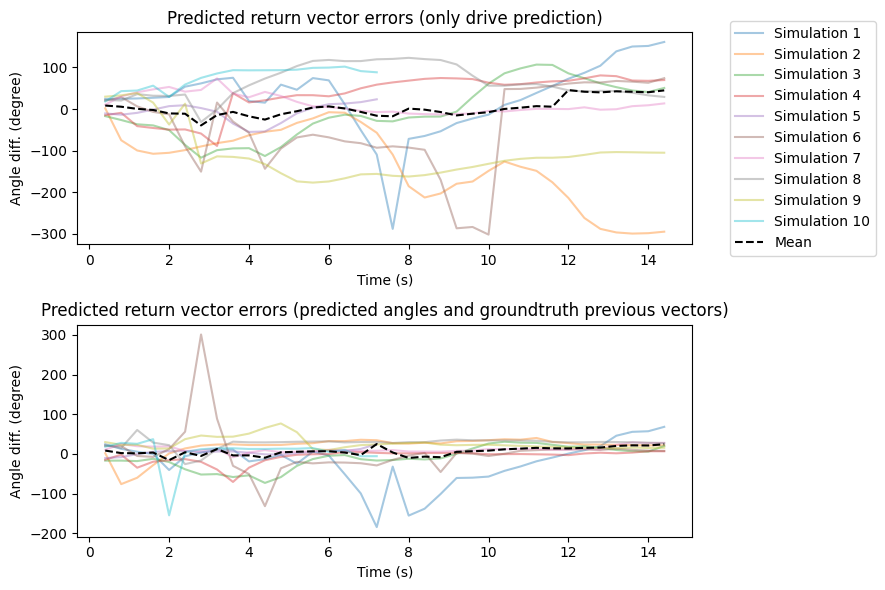

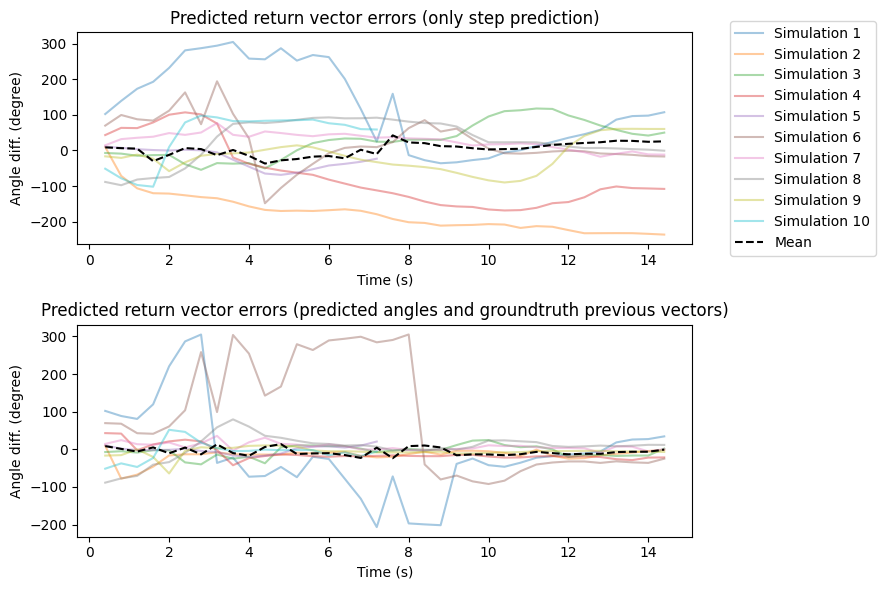

In [7]:
# Plotting subplots of return heading errors (angles) predicted with "Drive" prediction method
plt.figure(figsize=(9, 6))
plot_angles_subplot(angles_drive_accuracy_hist, "Predicted return vector errors (only drive prediction)", 1)
plot_angles_subplot(angles_drive_accuracy_ref_hist, "Predicted return vector errors (predicted angles and groundtruth previous vectors)", 2)
plt.tight_layout()
plt.show()

# Plotting subplots of return heading errors (angles) predicted with "Step length" prediction method
plt.figure(figsize=(9, 6))
plot_angles_subplot(angles_step_accuracy_hist, "Predicted return vector errors (only step prediction)", 1)
plot_angles_subplot(angles_step_accuracy_ref_hist, "Predicted return vector errors (predicted angles and groundtruth previous vectors)", 2)
plt.tight_layout()
plt.show()



# Models comparison

In [8]:
# Store in a single list all errors obtained using these four different prediction methods
mean_drive = mean_computation(angles_drive_accuracy_hist)
mean_drive_ref = mean_computation(angles_drive_accuracy_ref_hist)
mean_step = mean_computation(angles_step_accuracy_hist)
mean_step_ref = mean_computation(angles_step_accuracy_ref_hist)

-0.011107893820505657
0.9911442227943734


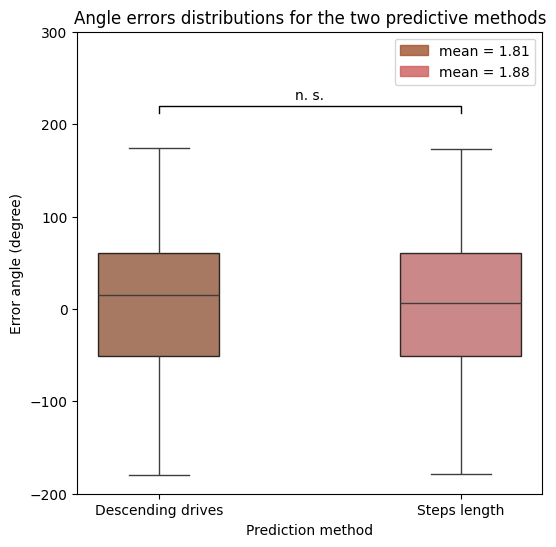

In [9]:
# Creat a data frame containing the errors obtained using "Drive" prediction method and "Step length" one
df = pd.DataFrame({'Descending drives': mean_drive, 'Steps length': mean_step})

# Calculating the means
mean_d = np.mean(mean_drive)
mean_s = np.mean(mean_step)

plt.figure(figsize=(6, 6))

# Plotting the parallel box plot with seaborn
ax = sns.boxplot(data=df, width=0.4, palette=['sienna', 'indianred'], boxprops=dict(alpha=0.8, edgecolor='black'))

# Adding labels and title
plt.xlabel('Prediction method')
plt.ylabel('Error angle (degree)')
plt.title('Angle errors distributions for the two predictive methods')

# Creating custom legend
legend_handles = [Patch(color='sienna', alpha=0.8, label=f'mean = {mean_d:.2f}'),
                  Patch(color='indianred', alpha=0.8, label=f'mean = {mean_s:.2f}')]
ax.legend(handles=legend_handles, loc='upper right')

# Performing the paired t-test
statistic, p_value = ttest_rel(df['Descending drives'], df['Steps length'])
print(statistic)
print(p_value)

# Plot significant bar
x1 = 0
x2 = 1
level = 1
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * level) + plt.ylim()[1]  # Top of the plot
bar_tips = bar_height - (y_range * 0.02)
plt.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')

# Define "stars" significant symbol
p = p_value
if p < 0.001:
    sig_symbol = '***'
elif p < 0.01:
    sig_symbol = '**'
elif p < 0.05:
    sig_symbol = '*'
elif p >= 0.05:
    sig_symbol = 'n. s.'
text_height = bar_height + (y_range * 0.01)
plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# Show the plot
plt.ylim((-200, 300))
plt.show()

4.247553162606187
2.8298674336871576e-05


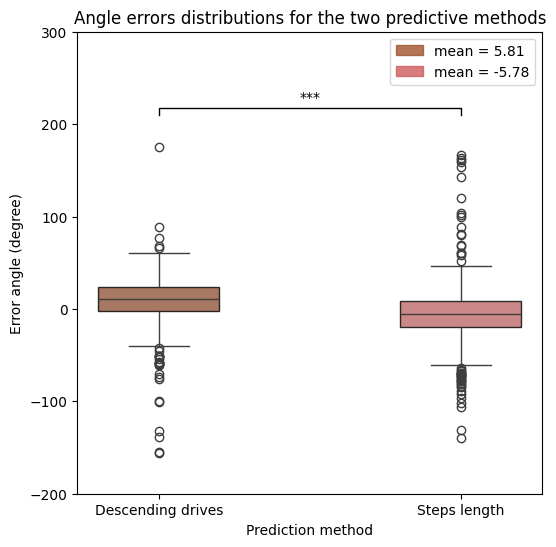

In [10]:
# Creat a data frame containing the errors obtained using "Drive" prediction method and "Step length" one
df = pd.DataFrame({'Descending drives': mean_drive_ref, 'Steps length': mean_step_ref})

# Calculating the means
mean_d = np.mean(mean_drive_ref)
mean_s = np.mean(mean_step_ref)

plt.figure(figsize=(6, 6))

# Plotting the parallel box plot with seaborn
ax = sns.boxplot(data=df, width=0.4, palette=['sienna', 'indianred'], boxprops=dict(alpha=0.8, edgecolor='black'))

# Adding labels and title
plt.xlabel('Prediction method')
plt.ylabel('Error angle (degree)')
plt.title('Angle errors distributions for the two predictive methods')

# Creating custom legend
legend_handles = [Patch(color='sienna', alpha=0.8, label=f'mean = {mean_d:.2f}'),
                  Patch(color='indianred', alpha=0.8, label=f'mean = {mean_s:.2f}')]
ax.legend(handles=legend_handles, loc='upper right')

# Performing the paired t-test
statistic, p_value = ttest_rel(df['Descending drives'], df['Steps length'])
print(statistic)
print(p_value)

# Plot the significant bar
x1 = 0
x2 = 1
level = 1
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * level) + plt.ylim()[1]  # Top of the plot
bar_tips = bar_height - (y_range * 0.02)
plt.plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')

# Define "stars" significant symbol
p = p_value
if p < 0.001:
    sig_symbol = '***'
elif p < 0.01:
    sig_symbol = '**'
elif p < 0.05:
    sig_symbol = '*'
elif p >= 0.05:
    sig_symbol = 'n. s.'
text_height = bar_height + (y_range * 0.01)
plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# Show the plot
plt.ylim((-200, 300))
plt.show()